# Lab 3 - Network Intrusion Detection
- Daniel Vance
- Peter Thung
- Ravi Srinivas
- Randy Balzer

## Business Understanding

### Describe the purpose of the data set you selected 
- *Why was this data collected in the first place?* - The data set selected is the "UNSW_NB15" network traffic data set. The data set was created to evaluate Network Intrusion Detection Systems (NIDS). According to the creators of the data set, N. Moustafa and J. Slay from the Australian Defence Force Academy, the "quality of a NIDS data set reflects two important characteristics: comprehensive reflection of contemporary threats and an inclusive normal range of traffic [1]." Before this data set was generated, they argued that existing data sets used to train and test NIDS were not representative of current traffic flows and threats[2].
- Describe how you would define and measure the outcomes from the dataset. That is: 
    - *Why is this data important?* - The importance of this data set is that it will allow NIDS to be evaluated better, which will increase their performance, increase their protective power and reduce the chance of false positives and false negatives.
    - *How do you know if you have mined useful knowledge from the dataset?* - We will know we mined useful knowledge from the data set if we can determine, based on a collection of packets of traffic data, whether the features of those packets indicate an attack or just normal traffic.
    - *How would you measure the effectiveness of a good prediction algorithm? Be specific.*
    
With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:

1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad). Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

*Source*
1. Moustafa, Nour, and Jill Slay. "UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)."Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015.
2. Moustafa, Nour, and Jill Slay. "The evaluation of Network Anomaly Detection Systems: Statistical analysis of the UNSW-NB15 data set and the comparison with the KDD99 data set." Information Security Journal: A Global Perspective (2016): 1-14.
3. https://www.unsw.adfa.edu.au/australian-centre-for-cyber-security/cybersecurity/ADFA-NB15-Datasets/

## Data Understanding

In [3]:
# Imports
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs


%matplotlib inline

In [4]:
# Load UNSW_NB15 into a Pandas dataframe
# df = pd.read_csv('https://github.com/danielbots/network_intrusion_detection_system/blob/master/UNSW_NB15_training_set.csv') # read in the csv file
df = pd.read_csv('UNSW_NB15_training_set.csv')

In [5]:
# df.describe() calculates the count, mean, standard deviation, min, max, and quartiles 
# of the data less the nominal (object) columns. 
df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [6]:
# List the unique values of each nominal column
header = df.columns.values.tolist()
for column in header:
    if column in df.select_dtypes(include=["object"]):
        print (column + ":\n"), df[column].unique()

proto:

service:

state:

attack_cat:



### Verify data quality: Explain any missing values, duplicate data, and outliers.
    - Are those mistakes? How do you deal with these problems? Be specific.

In [7]:
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records
df = df[df.is_ftp_login != 2]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 45 columns):
id                   82328 non-null int64
dur                  82328 non-null float64
proto                82328 non-null object
service              82328 non-null object
state                82328 non-null object
spkts                82328 non-null int64
dpkts                82328 non-null int64
sbytes               82328 non-null int64
dbytes               82328 non-null int64
rate                 82328 non-null float64
sttl                 82328 non-null int64
dttl                 82328 non-null int64
sload                82328 non-null float64
dload                82328 non-null float64
sloss                82328 non-null int64
dloss                82328 non-null int64
sinpkt               82328 non-null float64
dinpkt               82328 non-null float64
sjit                 82328 non-null float64
djit                 82328 non-null float64
swin                 82328 non-n

### Outliers

In [8]:
# using += 1.5 IQR to determine outliers from continous/oridnal numbers. 
df_desc_table = df.describe() # result: 41 numeric types
col_rate = df_desc_table['rate']
df_sub2 =df[['rate']]

q1 = df_desc_table.iloc[4]['rate']  # 4 = 25% row of description table or Q1
q3 = df_desc_table.iloc[6]['rate']  # 6 = 75% row of description table or Q3
iqr = q3 - q1
upper_outlier_threshold = q3 + (1.5 * iqr) 
lower_outlier_threshold = q1 - (1.5 * iqr)

col_index = df.columns
col_index.get_values() # Returns an array of column names 
col = df['rate']
lower_outliers = col[col < lower_outlier_threshold]
upper_outliers = col[col > upper_outlier_threshold]

print ("Number of observations", len(col))
print ("Number of lower outliers", len(lower_outliers))
print ("Number of upper outliers", len(upper_outliers))

Number of observations 82328
Number of lower outliers 0
Number of upper outliers 6201


In [9]:
# Code that calculates the number of outliers below and above for continous numeric features.
# this is to help determine which particular feature to do box plots on.
#ref: http://stackoverflow.com/questions/24901766/python-how-to-get-column-names-from-pandas-dataframe-but-only-for-continuous
df_cont = df.select_dtypes(['float64', 'int64']) # a data frame of just continous variables
### len(df_cont.columns)
#df_cont.drop('id', axis=1, inplace=True) # 1 is the axis number ( 0 for rows 1 for columns), dropping id as it doesn't make sense to plot outliers for that column
### len(df_cont.columns)
print ("Column name: #obserations: #lower_outliers: #upper_outliers: Max Values")
num_features_with_outliers = 0
for col_name in df_cont.columns:
    q1 = df_desc_table.iloc[4][col_name]  # 4 = 25% row of description table or Q1
    q3 = df_desc_table.iloc[6][col_name]  # 6 = 75% row of description table or Q3
    max_val = df_desc_table.iloc[7][col_name] # 7 = max value
    iqr = q3 - q1
    upper_outlier_threshold = q3 + (1.5 * iqr) 
    lower_outlier_threshold = q1 - (1.5 * iqr)
    col = df[col_name]
    lower_outliers = col[col < lower_outlier_threshold]
    upper_outliers = col[col > upper_outlier_threshold]
    if (len(lower_outliers) + len(upper_outliers)) > 0:
        num_features_with_outliers+=1
        print (col_name + ": " + str(len(col)) + " : " + str(len(lower_outliers)) + " : " + str(len(upper_outliers)) + " : " + str(max_val))
print ("Number of features with outliers: " + str(num_features_with_outliers))

Column name: #obserations: #lower_outliers: #upper_outliers: Max Values
dur: 82328 : 0 : 5868 : 59.999989
spkts: 82328 : 0 : 10196 : 10646.0
dpkts: 82328 : 0 : 8907 : 11018.0
sbytes: 82328 : 0 : 9270 : 14355774.0
dbytes: 82328 : 0 : 12308 : 14657531.0
rate: 82328 : 0 : 6201 : 1000000.003
sload: 82328 : 0 : 6715 : 5268000256.0
dload: 82328 : 0 : 18112 : 20821108.0
sloss: 82328 : 0 : 5499 : 5319.0
dloss: 82328 : 0 : 11272 : 5507.0
sinpkt: 82328 : 0 : 5667 : 60009.992
dinpkt: 82328 : 0 : 4717 : 57739.24
sjit: 82328 : 0 : 6320 : 1483830.917
djit: 82328 : 0 : 8569 : 463199.2401
tcprtt: 82328 : 0 : 2019 : 3.821465
synack: 82328 : 0 : 2954 : 3.226788
ackdat: 82328 : 0 : 2480 : 2.928778
smean: 82328 : 0 : 11928 : 1504.0
dmean: 82328 : 0 : 9902 : 1500.0
trans_depth: 82328 : 0 : 7582 : 131.0
response_body_len: 82328 : 0 : 5657 : 5242880.0
ct_srv_src: 82328 : 0 : 10093 : 63.0
ct_state_ttl: 82328 : 0 : 1833 : 6.0
ct_dst_ltm: 82328 : 0 : 10479 : 59.0
ct_src_dport_ltm: 82328 : 0 : 11476 : 59.0
ct_ds

Based on the code above there are 33 features with outliers based on 1.5 IQR standard. Note: Results were pulled out into excel to sort on number of outliers and max value to try and triage which variables to look at. Interesting to note: there were no lower outliers, just upper outliers. The top 5 features based on large number of outliers are [feature name (number of outliers)]: dload (18112) ct_dst_src_ltm (12789) dbytes(12308) smean(11928) ct_src_dport_ltm(11476)

Sorting by max_value will help to do box plots for variables with similar magnitude: E.g. 'dpkts', 'spkts' are similir in max value 'dloss', 'sloss' are similar in max value 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' are similar in max vax value

Looking at the histogram and boxplot for dpkts and spkts (below), there seems to be a lot of values very close to 0 and they seem to track each other in quantity. I wouldn't be surprised if they were highly correlated. They have very similar steep central distribution centered around 0. With the network setup I wouldn't expect packets to have more than 6 hops based on the network setup. Based on the summary statistics, 75% the dpkts and spkts have greater than 12, 10 respectively with max values of 10646.000000 11018.000000, respectively. It would be interesting to see if there may be any correlation with these values greater than 75% of the norm correlate to abnormal traffic. *See Explore relationships for further analysis with these particular features*. (Pearson Correlation heat map shows value of .37 , which indicates some postive correlation of small to medium strength). From an outlier perspective, however, it is not clear whether these packets are expected anomolies, or errors in recording. Will leave them in the dataset for now.

In [12]:
""" Compare the percentage of source to destination packets for Attack and for
    Normal traffic. We can see that Normal traffic accounts for 65% of
    the source to destination packets that are sent, while Attack only produce
    source to destination packets roughly 35% of the time. 
"""
denom = df[(df['spkts'] > 10)]
numerator = df[(df['spkts'] > 10) & (df['label'] == 1)]
print ("Percent of packets that have spkts > 12 and are labelled as an 'Attack' = " + str((float(len(numerator))/len(denom)) * 100))
numerator  = df[(df['spkts'] > 10) & (df['label'] == 0)]
print ("Percent of packets that have spkts > 12 and 'Normal' = " + str((float(len(numerator))/len(denom)) * 100))

Percent of packets that have spkts > 12 and are labelled as an 'Attack' = 34.577382556363965
Percent of packets that have spkts > 12 and 'Normal' = 65.42261744363603


Features dloss and sloss are the source or destination packets retransmitted or dropped. 
dloss and sloss also see to have a lot of values near zero and also seem to have roughly the same amount. We would not be surprised to see these variables correlate to each other. They have very similar steep central distribution centered around zero

Features 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' 
The features also seem to have a lot of values near 0 although slighly wider spread then previous features. Again, would not be surprised to see these variables correlate to each other. They have very similar steep central distribution centered around 0.

**Heat Maps** for every feature compared to *label*
- As noted above, we chose the 5 features with the most correlation, positive or negative.

In [13]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

#attack records
df1_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df1_1 = df1_1[df1_1.label == 1]

df1_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb']]
df1_2 = df1_2[df1_2.label == 1]

df1_3 = df[['label', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df1_3 = df1_3[df1_3.label == 1]

## normal records
df0_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df0_1 = df0_1[df0_1.label == 0]

df0_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb']]
df0_2 = df0_2[df0_2.label == 0]

df0_3 = df[['label', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df0_3 = df0_3[df0_3.label == 0]


## both attack and normal records
df_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'ct_src_dport_ltm', 'ct_dst_sport_ltm']]
df_3 = df[['label', 'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df_4 = df[['label', 'sinpkt', 'dinpkt', 'synack', 'ackdat', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm','ct_src_dport_ltm', 'ct_dst_sport_ltm']]
df_5 = df[['label', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']]

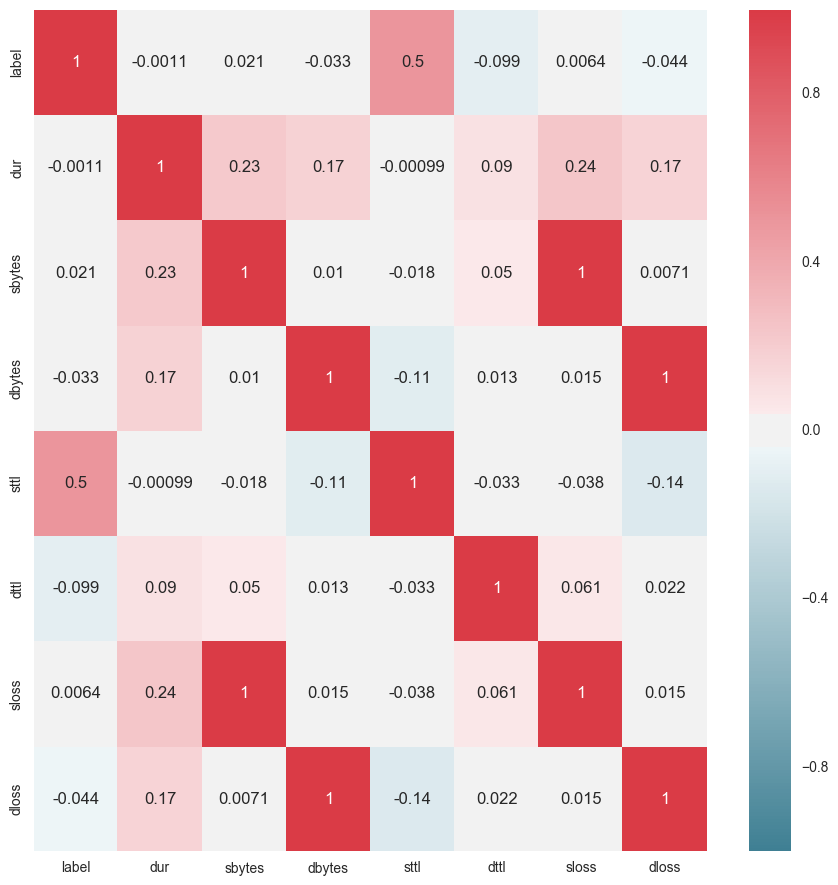

In [14]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_1.corr(), cmap=cmap, annot=True)

f.tight_layout()

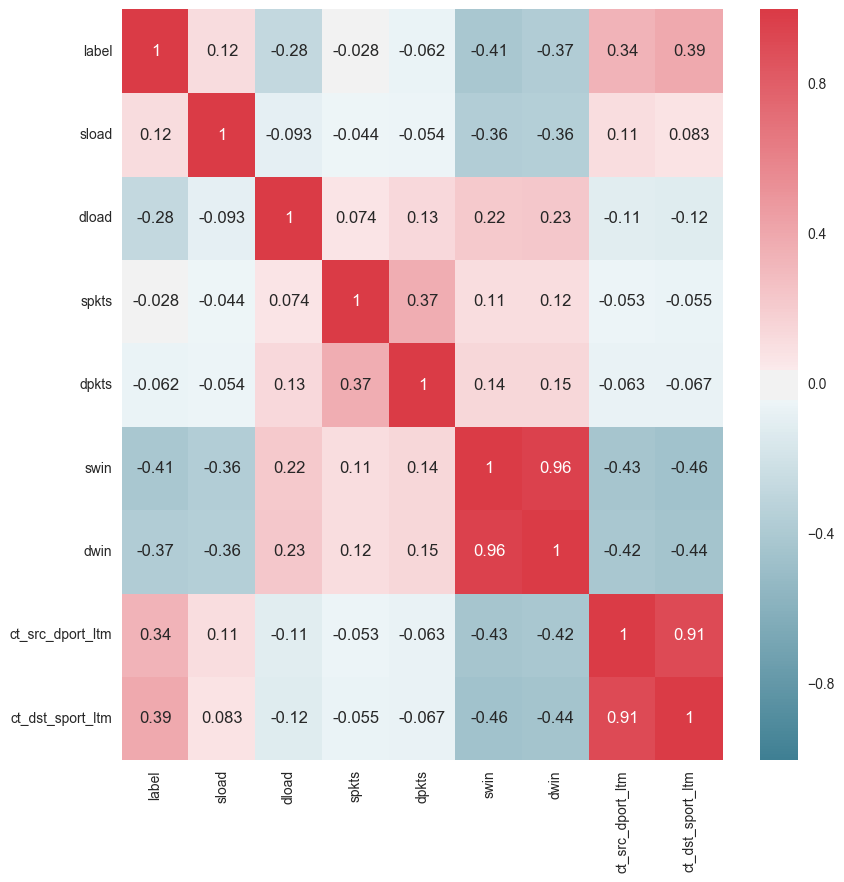

In [15]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_2.corr(), cmap=cmap, annot=True)

f.tight_layout()

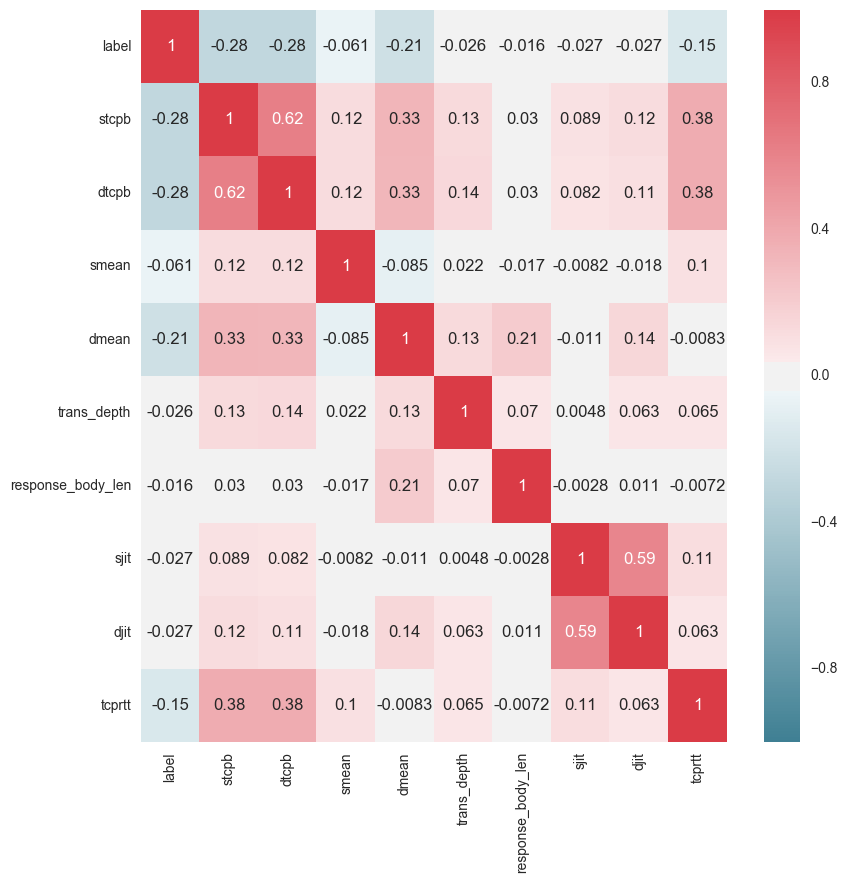

In [16]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_3.corr(), cmap=cmap, annot=True)

f.tight_layout()

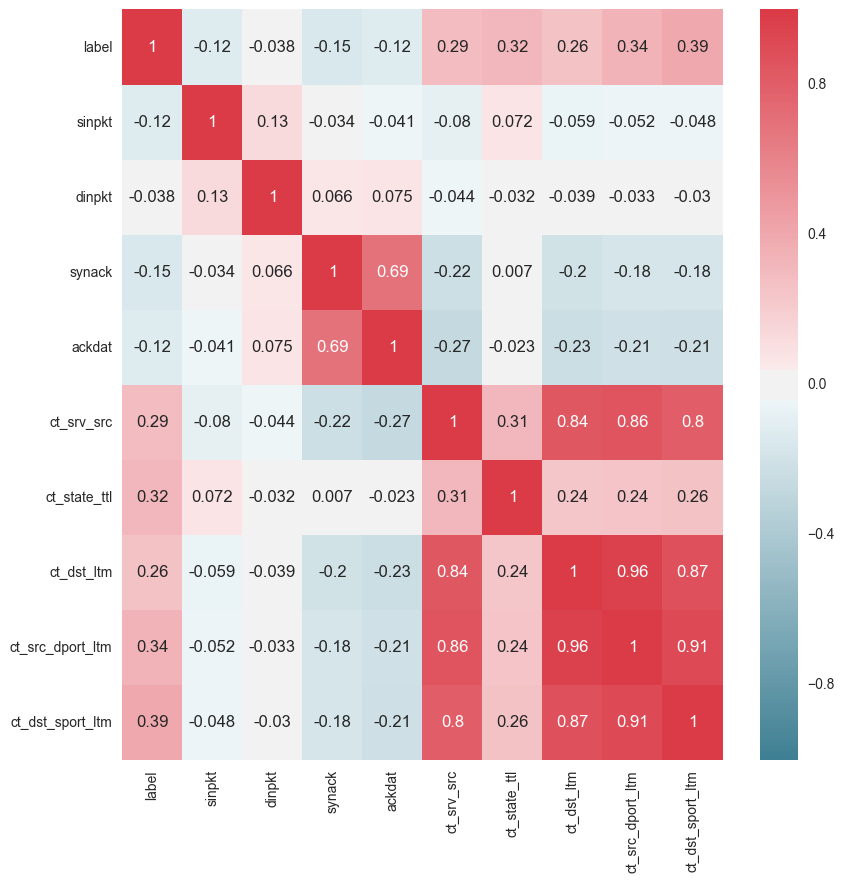

In [17]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_4.corr(), cmap=cmap, annot=True)

f.tight_layout()

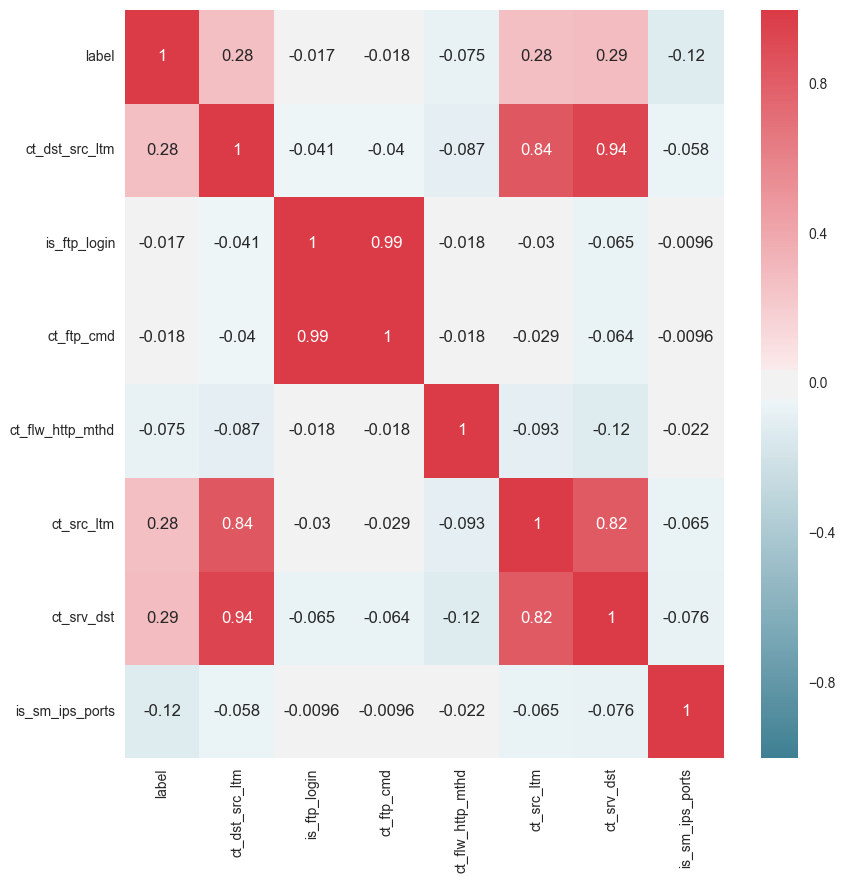

In [18]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_5.corr(), cmap=cmap, annot=True)

f.tight_layout()

**Scatter Plots** for interesting features

In [19]:
df_sub = df[['label', 'spkts', 'dpkts', 'dbytes', 'sbytes', 'rate', 'sloss', 'dloss', 'state', 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' ]]
df_corr = df_sub.corr(method='pearson')

header = df_sub.columns.values.tolist()
#print header
#len(header)
scatter_matrix(df_sub,figsize=(15, 10))

NameError: name 'scatter_matrix' is not defined

Looking at the scatter plot matrix, there appears to be varying degrees of positive linear correlation between the following features: dbytes - dloss; dpkts - dloss; sbytes sloss; spkts - sloss; ct_srv_src - ct_dst_src_ltm; dpkts - dbytes Other features are more difficult to find signifiant linear correlation due to binary nature of variable. The heat map below will help identify them visually based on color gradient which relates to strength.

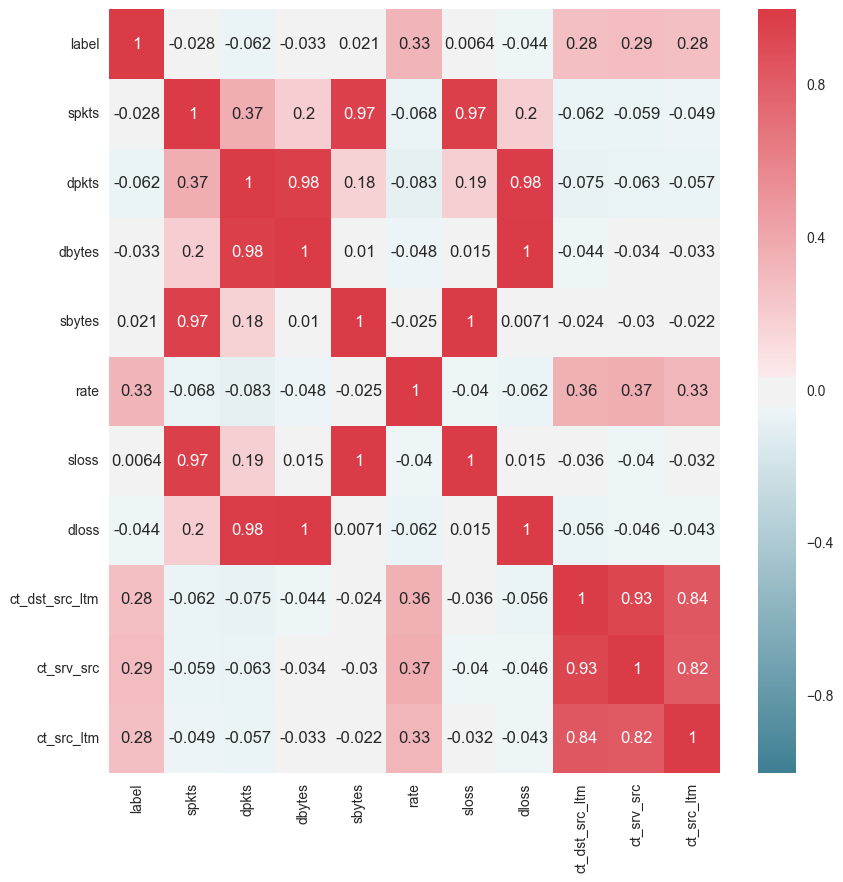

In [20]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df_corr, cmap=cmap, annot=True)
f.tight_layout()

## Modeling and Evaluation

#### Train and Adjust Parameters

In [ ]:
"""
    Models:
        K-Means - PETER
        MiniBatch - RANDY
        DBSCAN - RAVI
        GMM - DANIEL
"""

#### Evaluate and Compare

## MiniBatchKMeans





In [25]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print ("Value error({0}): ".format(e) )  # Note
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 202 entries, id to attack_cat_Worms
dtypes: float64(11), int64(30), uint8(161)
memory usage: 39.0 MB


In [26]:
# Go ahead and drop both 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 202 entries, id to attack_cat_Worms
dtypes: float64(11), int64(30), uint8(161)
memory usage: 39.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 201 entries, id to attack_cat_Worms
dtypes: float64(11), int64(29), uint8(161)
memory usage: 38.4 MB


In [39]:
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

n_clusters = 2

## KMeans
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1)
t0 = time.time()
k_means.fit(X)
t_kmeans = time.time() - t0


## MiniBatchKMeans
batch_size=100
mbk = MiniBatchKMeans(init='k-means++', n_clusters=2, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0


## DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=10)
t0 = time.time()
dbscan.fit(X)
t_dbscan = time.time() - t0


print ("kmeans train time: %.2fs"%(t_kmeans))
print ("mini batch train time: %.2fs"%(t_mini_batch))
print ("dbscan train time: %.2fs"%(t_dbscan))

kmeans train time: 1.07s
mini batch train time: 0.42s
dbscan train time: 28.73s


#### Visualize Results

In [ ]:
"""
    Can we visualize a data set with this many features?
    Can we visualize on the attack categories?
"""

#### Summarize the Ramifications

## Deployment

In this phase, we understand that our evaluation model has met business objectives and is receiving reliable score data. Making the model exceptionally useful for businesses & organizations seeking to protect assets from potential cyberattacks. The model’s performance and desirability rests on some identified variables being, the overall performance of the model to protect from attacks, the costs associated with attacks landed/ missed, and also “how well does the model grow?” These factors could help a customer’s decision making process to employing an algorithmic method. Ultimately our job would be to efficiently and effectively scale the methodology appropriately for each customer. Interested customers would have a clear understanding of the nature of their business and the amount of protection needed for their size of an organization. To properly deploy a model to the customer, they would need to be aware of the overhead related in performing certain algorithms, mostly being time and money. The updating process of such a model could be continuous, either by streaming in live time by the seconds or delivered in blocks of time, such as hourly/daily/weekly.

The customer would also have to make a decision on whether they wanted real time cyber attack protection or log scans. Real time coverage has overhead to consider, such as latency that the algorithm will cause, especially in high throughput networks. Log anaysis is much easier to implement, and if ran regularly enough, it may give the customers the reassurance they need that they have not been breached.

- *Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
- *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
- *How would your deploy your model for interested parties?*
- *What other data should be collected?*
- *How often would the model need to be updated, etc.?*

## Exceptional Work